In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip drive/MyDrive/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset_zurich/train/merger/587739097519292568.jpeg  
  inflating: dataset_zurich/train/merger/587736942527643944.jpeg  
  inflating: dataset_zurich/train/merger/588007004191588455.jpeg  
  inflating: dataset_zurich/train/merger/587738953106849840.jpeg  
  inflating: dataset_zurich/train/merger/587739721898328168.jpeg  
  inflating: dataset_zurich/train/merger/588007004191785072.jpeg  
  inflating: dataset_zurich/train/merger/588023045865603121.jpeg  
  inflating: dataset_zurich/train/merger/587736541474914354.jpeg  
  inflating: dataset_zurich/train/merger/587733081346605093.jpeg  
  inflating: dataset_zurich/train/merger/587736525374750812.jpeg  
  inflating: dataset_zurich/train/merger/587739720305213625.jpeg  
  inflating: dataset_zurich/train/merger/587726033328930880.jpeg  
  inflating: dataset_zurich/train/merger/587725041170055202.jpeg  
  inflating: dataset_zurich/train/merger/587736619324014666.jpeg  
  inflating

In [4]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# # Preparing dataset for Stratified Sampling.

# import shutil
# os.mkdir("data")
# os.mkdir("data/noninteracting")
# os.mkdir("data/merger")

# src_train_merger = "dataset_zurich/train/merger/"
# src_val_merger = "dataset_zurich/val/merger/"
# src_train_noninteracting = "dataset_zurich/train/noninteracting/"
# src_val_noninteracting = "dataset_zurich/val/noninteracting/"

# dest_merger = "data/merger/"
# dest_noninteracting = "data/noninteracting/"

# for filename in os.listdir(src_train_merger):
#   shutil.move(os.path.join(src_train_merger, filename), dest_merger)
# for filename in os.listdir(src_val_merger):
#   shutil.move(os.path.join(src_val_merger, filename), dest_merger)

# for filename in os.listdir(src_train_noninteracting):
#   shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
# for filename in os.listdir(src_val_noninteracting):
#   shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)

In [7]:
image = plt.imread("/content/dataset_zurich/train/merger/587722952231026743.jpeg")
image.shape

(631, 631, 3)

In [8]:
class InterpolateTransform:
  def __call__(self, img):
    from PIL import Image
    import cv2

    img = np.array(img)
    # img = torch.from_numpy(img).permute(2, 0, 1)
    # print(img.shape)
    # interpolated_img = F.interpolate(img, size=(150, 150), mode="bicubic", align_corners=True)
    # return Image.fromarray(interpolated_img.to_numpy())

    bicubic_img = cv2.resize(img, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    return Image.fromarray(bicubic_img)

In [9]:
data_transforms = {
    "train": transforms.Compose([
        # transforms.RandomResizedCrop(225),
        # transforms.RandomHorizontalFlip(),
        InterpolateTransform(),
        transforms.CenterCrop(250),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        # transforms.Resize(250),
        InterpolateTransform(),
        transforms.CenterCrop(250),
        # transforms.Resize(200),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        # transforms.Resize(250),
        # transforms.CenterCrop(224),
        # transforms.Resize(200),
        InterpolateTransform(),
        transforms.CenterCrop(250),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [10]:
data_dir = "/content/dataset_zurich"
types = ["train", "val", "test"]

batch_size = 8
shuffle = True
num_workers = 0

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in types}
image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms["test"])

dataloaders = {x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
              }

dataset_sizes = {x: len(image_datasets[x]) for x in types}
class_names = image_datasets['train'].classes

In [34]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

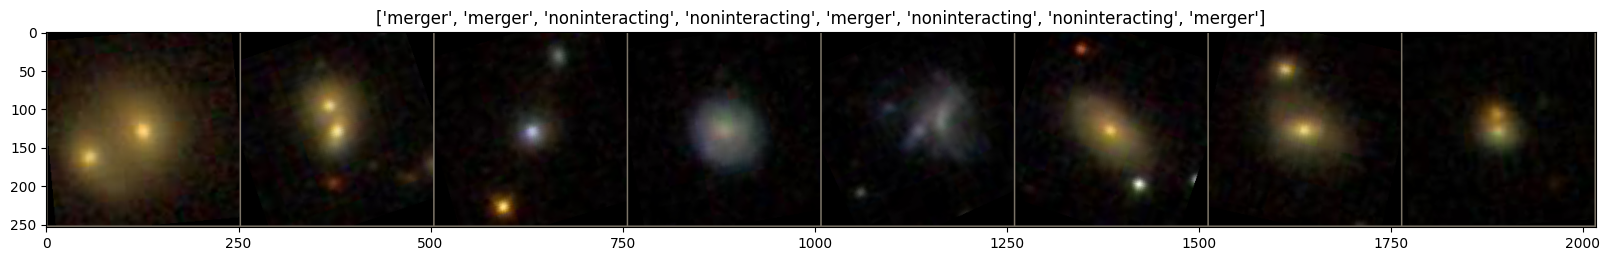

In [35]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20, 60))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
class_names

['merger', 'noninteracting']

In [14]:
dataset_sizes

{'test': 3998, 'train': 8003, 'val': 3999}

In [15]:
# # Visualize the effect of downsampling
# inputs, classes = next(iter(dataloaders['train']))

# def downsample_check(size=150, mode="nearest"):
#   inputs, labels = next(iter(dataloaders['train']))
  
#   plt.figure(figsize=(15, 40))
#   # "Original (top) vs Downsampled (bottom)"

#   if mode == "nearest":
#     # Observation: There's significant difference between clamping and not clamping.
#     intrp_inps = F.interpolate(inputs, size=size, mode=mode)
#   elif mode == "bicubic":
#     intrp_inps = F.interpolate(inputs, size=size, mode=mode, align_corners=True).clamp(min=0, max=255)

#   out_intrp = torchvision.utils.make_grid(intrp_inps)
#   out = torchvision.utils.make_grid(inputs)

#   imshow(out, title=[class_names[x] for x in classes])
#   imshow(out_intrp, title=[class_names[x] for x in classes])

# downsample_check()
# downsample_check(mode="bicubic")

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(2048, 288)
        self.fc2 = nn.Linear(288, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        # clamp is required due to the nature of bicubic interpolation. See "Note" in https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html#torch.nn.functional.interpolate
        # x = F.interpolate(x, size=(150, 150), mode="bicubic", align_corners=True)
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        # x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.dropout(x)
        # x = self.pool(x)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()
model = model.to(device)

In [17]:
model

Model(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=2048, out_features=288, bias=True)
  (fc2): Linear(in_features=288, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [19]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=20)  # After every 20 epochs, decrease the lr by `gamma` (= 0.1 by default)

epochs = 50

In [20]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    epochs_no_improve = 0  # Track how many epochs with no decrease in validation loss
    n_epochs_stop = 6  # Stop if no decrement in validation loss after 5 consecutive epochs.
    early_stop = False
    min_val_loss = np.Inf

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Training mode
            else:
                model.eval()   # Evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
              inputs = inputs.to(device)
              labels = labels.to(device)

              # zero the parameter gradients
              optimizer.zero_grad()

              # forward
              # track history if only in train
              with torch.set_grad_enabled(phase == 'train'):    
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # ### EARLY STOPPING ###
            # if phase == "val" and epoch_loss < min_val_loss:
            #   epochs_no_improve = 0
            #   min_val_loss = epoch_loss
            # elif phase == "val" and epoch_loss >= min_val_loss:
            #   epochs_no_improve += 1
            
            # if epoch > 5 and (epochs_no_improve == n_epochs_stop):
            #   print("Early stopping!")
            #   return  # Way to come out of all nested loops
            
            # ### end ###

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
trained_model = train_model(model, criterion, optimizer, scheduler=None, num_epochs=epochs)

Epoch 0/49
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.4840 Acc: 0.7828
val Loss: 0.3719 Acc: 0.8502

Epoch 1/49
----------
train Loss: 0.3386 Acc: 0.8662
val Loss: 0.3222 Acc: 0.8935

Epoch 2/49
----------
train Loss: 0.2738 Acc: 0.8995
val Loss: 0.2687 Acc: 0.9127

Epoch 3/49
----------
train Loss: 0.2497 Acc: 0.9077
val Loss: 0.2349 Acc: 0.9175

Epoch 4/49
----------
train Loss: 0.2203 Acc: 0.9143
val Loss: 0.2382 Acc: 0.9150

Epoch 5/49
----------
train Loss: 0.2207 Acc: 0.9158
val Loss: 0.2662 Acc: 0.8990

Epoch 6/49
----------
train Loss: 0.2053 Acc: 0.9265
val Loss: 0.2005 Acc: 0.9237

Epoch 7/49
----------
train Loss: 0.2067 Acc: 0.9223
val Loss: 0.2157 Acc: 0.9215

Epoch 8/49
----------
train Loss: 0.1986 Acc: 0.9233
val Loss: 0.2042 Acc: 0.9307

Epoch 9/49
----------
train Loss: 0.1956 Acc: 0.9279
val Loss: 0.2034 Acc: 0.9290

Epoch 10/49
----------
train Loss: 0.1888 Acc: 0.9314
val Loss: 0.2053 Acc: 0.9297

Epoch 11/49
----------
train Loss: 0.1850 Acc: 0.9330
val Loss: 0.1883 Acc: 0.9387

Epoch 12/49
----------
t

In [23]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []

model.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model(inputs)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 94.7223611805903


In [24]:
preds_ = np.concatenate([pred.cpu().numpy() for pred in all_preds])

In [25]:
preds_

array([1, 1, 0, ..., 0, 0, 1])

In [26]:
targets_ = np.concatenate([target.cpu().numpy() for target in all_targets])

In [27]:
from sklearn.metrics import  confusion_matrix, classification_report

In [28]:
print(confusion_matrix(targets_, preds_))
print("\n")
print(classification_report(targets_, preds_))

[[1375  123]
 [  88 2412]]


              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1498
           1       0.95      0.96      0.96      2500

    accuracy                           0.95      3998
   macro avg       0.95      0.94      0.94      3998
weighted avg       0.95      0.95      0.95      3998



In [29]:
!pip install plot-metric

In [30]:
from plot_metric.functions import BinaryClassification

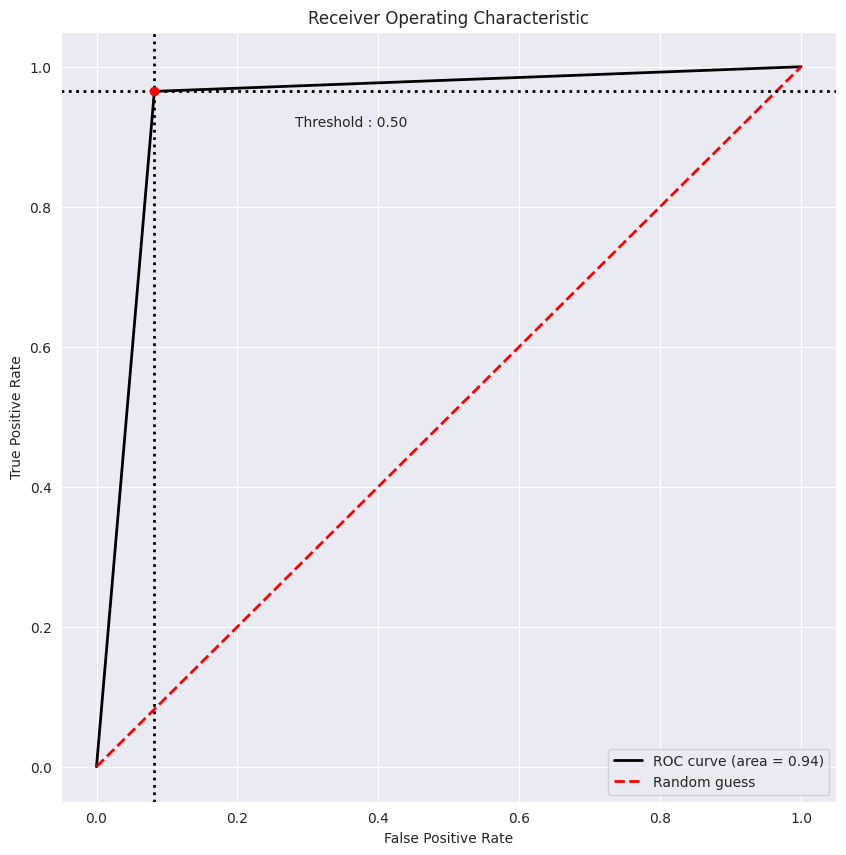

In [31]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds_, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()